In [ ]:
import sys
import numpy as np
from sklearn import svm
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

  ## DataSet representation
  CIFAR-10 dataset. Contains 60,000 32x32x3 (RGB) images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.

The classes are: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship and Truck.

## Main goal
Predict the class label of a given image according to the pixels value it has.

In [ ]:
# getting the data from the website
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-02-19 17:35:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  56.1MB/s    in 2.9s    

2023-02-19 17:35:11 (56.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
# extracting the zip file that we recieved
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# Diving the data to train and test
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# Diving the full train into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.2, random_state = 42)

In [ ]:
# We have 50k images to train on
x_train_full.shape

(50000, 32, 32, 3)

In [ ]:
# And 10k images to test on
x_test.shape

(10000, 32, 32, 3)

In [ ]:
# Function that "translate" a label number to the class type it presents
def label_numbers_to_clothes(labels):
    casting = {0 :'Airplane',
               1 :'Automobile',
               2 :'Bird',
               3 :'Cat',
               4 :'Deer',
               5 :'Dog',
               6 :'Frog',
               7 :'Horse',
               8 :'Ship',
               9 :'Truck'}
    label_copy = labels.copy().map(casting)
    return label_copy

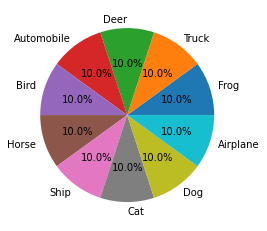

In [ ]:
# Let's check if the data is really distributed equally
targets_train_series = pd.Series(y_train_full.flatten())
items_dict = dict(targets_train_series.value_counts())
labels = items_dict.keys()
labels = pd.Series(labels)
values = items_dict.values()
plt.pie(values, labels=label_numbers_to_clothes(labels), autopct='%1.1f%%')
plt.show()

##### As we can see, each label number (class type) has the same data percent as everyone else, means that the data is perfectly balanced.

In [ ]:
# Scaling the pixels data from 0 - 1
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [ ]:
# confusion matrix
def conf_matrix(val_labels_pred, val_labels):
  label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  plt.figure(figsize=(8,8))
  sb.heatmap(confusion_matrix(val_labels, val_labels_pred), cmap = "Blues", annot=True, fmt = '.0f', xticklabels=label_names, yticklabels=label_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

##### For using the models we've learned in the course, we'll need to convert the image to grayscale 1D array for better predictions.

In [ ]:
# converting the image to gray scale
def rgb2gray(x):
    return np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])

x_train_gray = rgb2gray(x_train)
x_val_gray = rgb2gray(x_val)
x_test_gray = rgb2gray(x_test)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], x_train_gray.shape[1], x_train_gray.shape[2])
x_val_gray = x_val_gray.reshape(x_val_gray.shape[0], x_val_gray.shape[1], x_val_gray.shape[2])
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], x_test_gray.shape[1], x_test_gray.shape[2])

In [ ]:
# flatten the images from 32x32 to 1024 (32x32)
x_train_gray = x_train_gray.reshape(-1, 1024)
x_val_gray = x_val_gray.reshape(-1, 1024)

# convert labels from a 2D array to 1D array
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

# scaling the pixels 
basic_scale = StandardScaler()
x_train_gray = basic_scale.fit_transform(x_train_gray)
x_val_gray = basic_scale.transform(x_val_gray)

#**Models we learned**
##**DecisionTree**
 The goal of DecisionTree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

 ### Challanges
 First we ran the model on it's default parameters and the model just kept running without stopping. To overcome this problem we changed the paramaters of this model and tried to maximize the predictions outcome.

Eventually, we saw that the max depth on 10 gave us the best score.

In [ ]:
# DecisionTree
def Decision_tree(train_features, train_labels, val_features, val_labels):
  # initialize the decision tree classifier
  desicion_tree = DecisionTreeClassifier(max_depth=10)
  
  # fit the DecisionTree classifier on the training data
  desicion_tree.fit(train_features, train_labels)

  # make predictions on the validation data
  decision_tree_val_pred = desicion_tree.predict(val_features)
  
  # calculate the accuracy score
  decision_acc = accuracy_score(val_labels, decision_tree_val_pred)
  
  return decision_acc, decision_tree_val_pred

##**AdaBoost**
AdaBoost is an ensemble learning algorithm that combines weak learners into a strong classifier by sequentially applying a weighted training set to each weak learner. The algorithm assigns higher weights to the misclassified training instances in each iteration, making the subsequent weak learners focus more on those instances.

 ## Challanges
 First we didn't know which base estimator and how many num estimators will maximize out score predictions. For knowing this we ran the model on several different parameters for the base estimators.

Eventually we saw that from 250 estimators and more, the model gave lower score and for that reason we stopped at 200 estimators in our final run. 

In [ ]:
# AdaBoost
def ada_boost(train_features, train_labels, val_features, val_labels):
  final_num_estimators = 50
  max_score = -sys.maxsize # minus infinity
  best_ada_pred = 0
  num_estimators = 50 # default
  depths = [5, 10]
  best_depth = 0
  for i in range (0, 4): # this for is for choosing the best n_estimators
    for d in depths:
      # initialize the Adaboost classifier
      ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = d), n_estimators = num_estimators)

      # fit the Adaboost classifier on the training data
      ada.fit(train_features, train_labels)

      # make predictions on the validation data
      ada_pred = ada.predict(val_features)

      # calculate the accuracy score
      ada_val_acc = accuracy_score(val_labels, ada_pred)
      if (ada_val_acc > max_score):
          final_num_estimators = num_estimators
          max_score = ada_val_acc
          best_ada_pred = ada_pred
          best_depth = d

      print("AdaBoost with max depth: ", d ," and n_estimators: ", num_estimators, " gave the score of: ", ada_val_acc)
    num_estimators += 50

  return final_num_estimators, best_depth, max_score, best_ada_pred

##**SVM**
Support Vector Machines (SVM) is a powerful classification algorithm that finds the optimal hyperplane that separates the data points of different classes with the maximum margin. SVMs can use different kernel functions to map the input data into a higher-dimensional space, where it becomes easier to find the optimal hyperplane.

## Challanges
To make the SVM fit our data, we saw that we need to observe some different kernel function and see which one will give us the best score.

In [ ]:
# SVM
def svm_classifier(train_features, train_labels, val_features, val_labels):
  kernel_arr = ['linear', 'poly', 'rbf']
  index = 0
  max_score = -sys.maxsize # minus infinity
  best_svm_pred = 0
  for i in range(0, 3):
    # initialize the SVM classifier
    SVM = svm.SVC(max_iter=100000, kernel=kernel_arr[i])

    # fit the Adaboost classifier on the training data
    SVM.fit(train_features, train_labels)
    
    # make predictions on the validation data
    val_pred = SVM.predict(val_features)

    # calculate the accuracy score
    svm_acc = accuracy_score(val_labels, val_pred)

    print(kernel_arr[i],' kernel gave the score of: ', svm_acc)

    if (svm_acc > max_score):
        index = i
        max_score = svm_acc
        best_svm_pred = val_pred
        
  return kernel_arr[index], max_score, best_svm_pred

##**KNN**
K-Nearest Neighbors (KNN) is a simple but effective classification algorithm that works by calculating the distance between the query instance and all the training samples. The KNN algorithm selects the K number of nearest neighbors to the query instance and classifies the query instance based on the majority vote of its K nearest neighbors. 

## Challanges
For maximizing the KNN we need to check what number of neighbors will give us the best predictions, for that reason we ran on several number of neighbors, and recieved the number of neighbors that gave us the best score.

Eventually we saw that from 11 neighbors and more, the prediction gets worse, and for that reason we stopped checking in 9 neighbors in our final run.

In [ ]:
# KNN
def KNN(train_features, train_labels, val_features, val_labels):
  # initialize the KNN classifier
  knn_clf = KNeighborsClassifier()

  # fit the KNN classifier on the training data
  knn_clf.fit(train_features,train_labels)

  # make predictions on the validation data
  knn_pred = knn_clf.predict(val_features)

  # calculate the accuracy score
  knn_val_acc = accuracy_score(val_labels, knn_pred)
  print("default knn accuracy: ", knn_val_acc)

  # finding the best k using cross validation
  index = 0
  max_score = -sys.maxsize # minus infinity
  for i in [1, 3, 5, 7, 9]:
      knn_acc = cross_val_score(KNeighborsClassifier(n_neighbors = i), train_features, train_labels, cv = 10).mean()
      if (knn_acc > max_score):
          index = i
          max_score = knn_acc

  # initialize the best KNN classifier
  best_knn_clf = KNeighborsClassifier(n_neighbors = index)

  # fit the best KNN classifier on the training data
  best_knn_clf.fit(train_features,train_labels)

  # make predictions on the validation data
  knn_pred = best_knn_clf.predict(val_features)

  # calculate the accuracy score
  knn_val_acc = accuracy_score(val_labels, knn_pred)

  return index, knn_val_acc, knn_pred

**Running the models**

Decision tree gave the score of:  0.2525


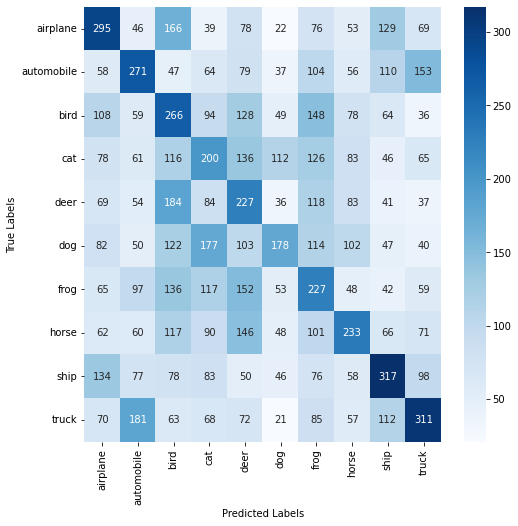

In [ ]:
# running decision tree
decision_tree_val_acc, decision_tree_val_pred = Decision_tree(x_train_gray, y_train, x_val_gray, y_val)
print("Decision tree gave the score of: ", decision_tree_val_acc)

# Let's present the confusion matrix
conf_matrix(decision_tree_val_pred, y_val)

In [ ]:
# running ada_boost
final_num_estimators, best_depth, ada_val_acc, ada_val_pred = ada_boost(x_train_gray, y_train, x_val_gray, y_val)
print("AdaBoost with depth: ", best_depth ," and n_estimators: ", final_num_estimators, " gave the best score of: ", ada_val_acc)

# Let's present the confusion matrix
conf_matrix(ada_val_pred, y_val)

AdaBoost with max depth:  5  and n_estimators:  50  gave the score of:  0.3219
AdaBoost with max depth:  10  and n_estimators:  50  gave the score of:  0.2608
AdaBoost with max depth:  5  and n_estimators:  100  gave the score of:  0.3245


Note: In the cell block above we ran the ada boost on our data, this cell takes a lot of hours to run. We already ran it and acciedently ran it again and this is the reason this is the cell that does'nt have it's final outcome. The outcome of this was around 0.3 ~ 0.33.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


linear  kernel gave the score of:  0.1504
poly  kernel gave the score of:  0.3545
rbf  kernel gave the score of:  0.4529
kernel:  rbf  gave the best score of:  0.4529


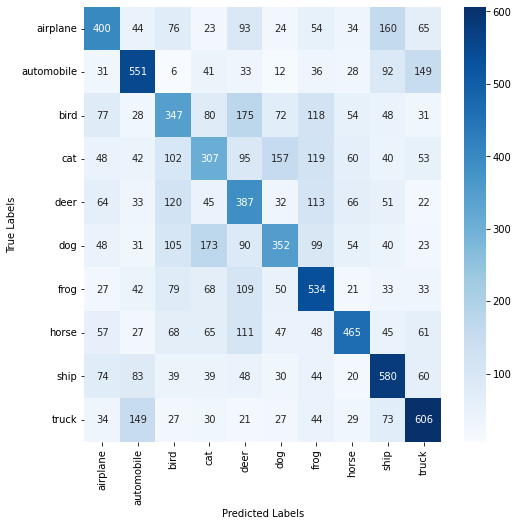

In [ ]:
# running SVM
final_kernel, svm_val_acc, svm_val_pred = svm_classifier(x_train_gray, y_train, x_val_gray, y_val)
print("kernel: ", final_kernel, " gave the best score of: ", svm_val_acc)

# Let's present the confusion matrix
conf_matrix(svm_val_pred, y_val)

default knn accuracy:  0.2791
neighbors amout:  1  gave the best score of:  0.2893


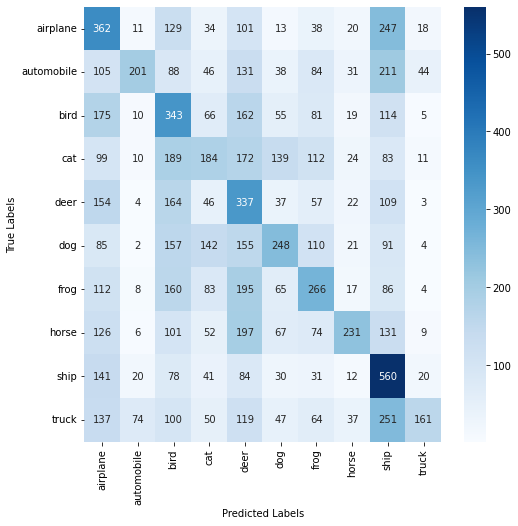

In [ ]:
# running knn
neighbors_amount, knn_val_acc, knn_val_pred = KNN(x_train_gray, y_train, x_val_gray, y_val)
print("neighbors amout: ", neighbors_amount, " gave the best score of: ", knn_val_acc)

# Let's present the confusion matrix
conf_matrix(knn_val_pred, y_val)

Each image has a lot of pixels, by that our model can be really complex and may cause overfitting. let's see if we can improve our predictions while using dimentional reduction.

##**PCA**

In [ ]:
# Dimensional reduction using PCA
pca = PCA()
pca.fit(x_train_gray)

PCA()

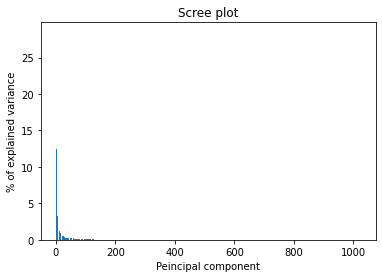

In [ ]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('% of explained variance')
plt.xlabel('Peincipal component')
plt.title('Scree plot')
plt.show()

##### As we can see from the Scree plot above, there's alot of pixels that are not playing a significal part in the label prediction.
##### For that reason we will perform dimentional reduction

In [ ]:
pca = PCA(n_components = 0.95)
x_train_reduced = pca.fit_transform(x_train_gray)
x_val_reduced = pca.transform(x_val_gray)
pca.n_components_

163

##### If we would like to get a 95% of our data accuracy, we need only 160 pixels.

##### That's great, but not enough.. let's try to reduce the number of pixels even more.

In [ ]:
pca = PCA(n_components = 0.9)
X_train_reduced = pca.fit_transform(x_train_gray)
X_val_reduced = pca.transform(x_val_gray)
pca.n_components_

79

##### To get a 90% of our data accuracy, we need only 77 pixels.

##### Let's continue doing so..

In [ ]:
pca = PCA(n_components = 0.85)
X_train_reduced = pca.fit_transform(x_train_gray)
X_val_reduced = pca.transform(x_val_gray)
pca.n_components_

45

##### To get a 85% of our data accuracy, we need only 45 columns.

##### Let's check the variance percentage in each of the 45 pixels

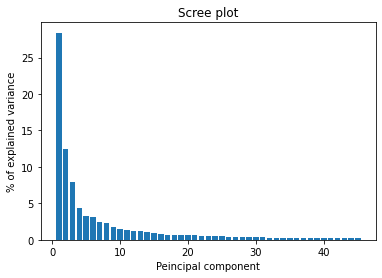

In [ ]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('% of explained variance')
plt.xlabel('Peincipal component')
plt.title('Scree plot')
plt.show()

##### Now the Scree plot looks way better.

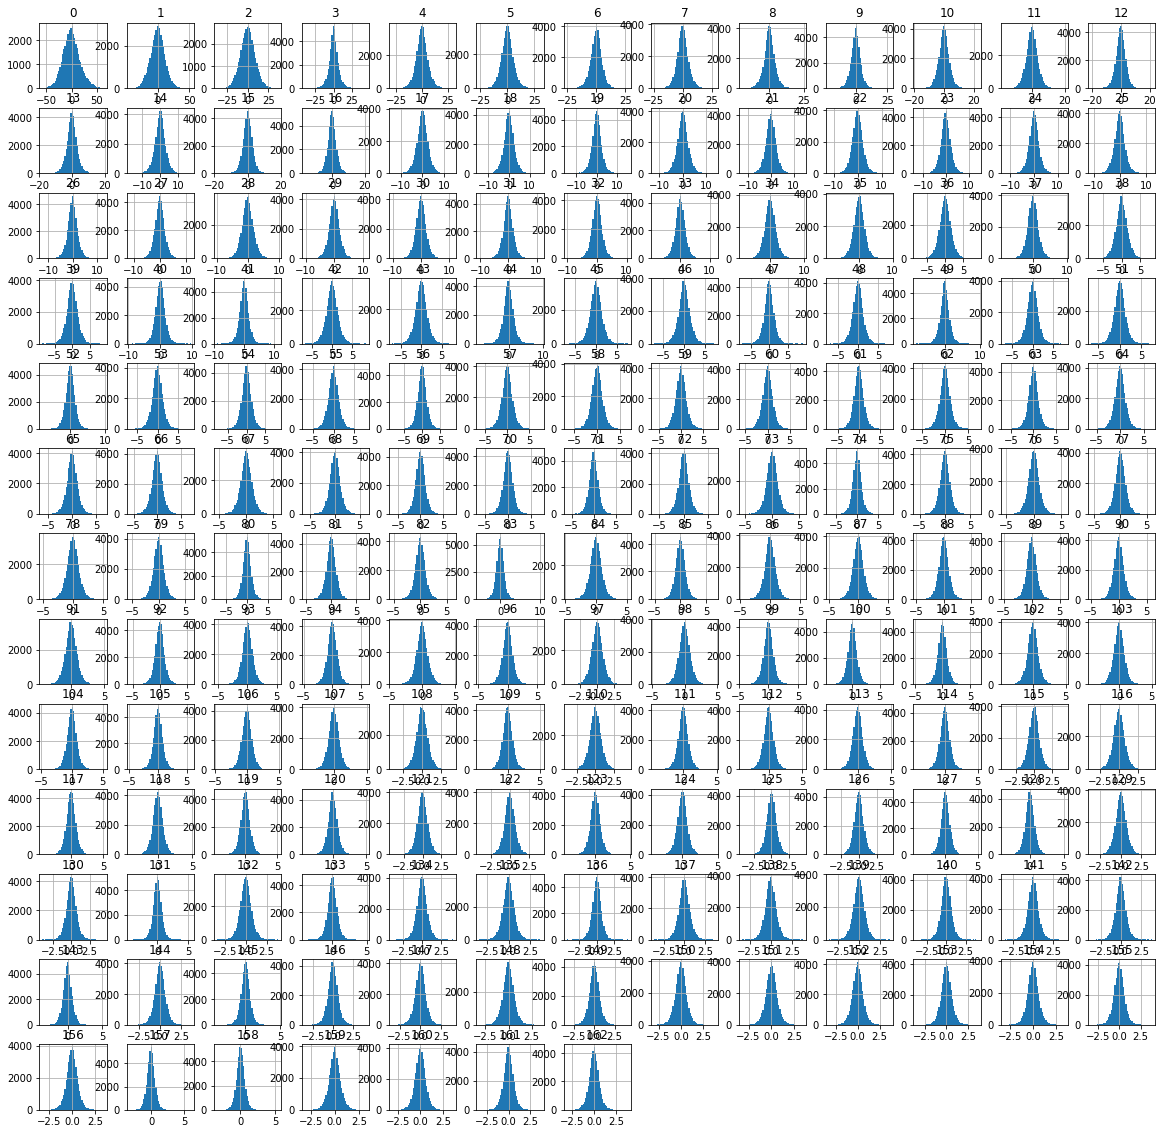

In [ ]:
# Let's present the data distribution
temp = pd.DataFrame(x_train_reduced)
temp.hist(bins=50, figsize=(20,20))
plt.show()

##### As we can see from the above, the data in most of the pixels is normally distributed.

In [ ]:
# scaling the dimentional reduced data
preprocess = Pipeline([('scaler', StandardScaler(with_std=False)), ('pca', PCA(n_components = 0.85))])
x_train_reduced = preprocess.fit_transform(x_train_reduced)
x_val_reduced = preprocess.transform(x_val_reduced)


**Running the models on the dimentional reduced data**

Decision tree gave the score of:  0.0967


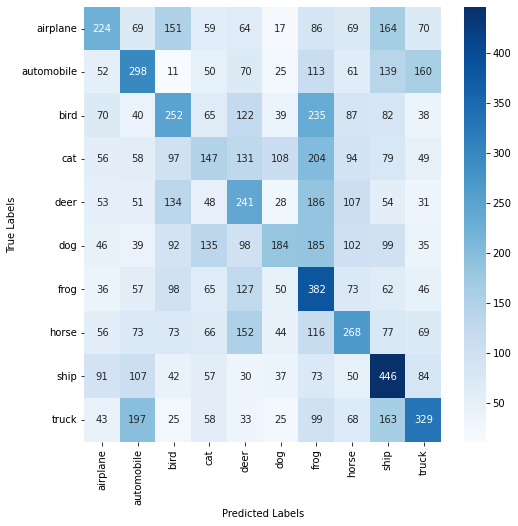

In [ ]:
# running decision tree
decision_tree_reduced_acc, decision_tree_reduced_pred = Decision_tree(x_train_reduced, y_train,x_val_reduced,y_test)
print("Decision tree gave the score of: ", decision_tree_reduced_acc)

# Let's present the confusion matrix
conf_matrix(decision_tree_reduced_pred, y_val)

AdaBoost with max depth:  5  and n_estimators:  50  gave the score of:  0.3206
AdaBoost with max depth:  10  and n_estimators:  50  gave the score of:  0.2622
AdaBoost with max depth:  5  and n_estimators:  100  gave the score of:  0.3141
AdaBoost with max depth:  10  and n_estimators:  100  gave the score of:  0.296
AdaBoost with max depth:  5  and n_estimators:  150  gave the score of:  0.305
AdaBoost with max depth:  10  and n_estimators:  150  gave the score of:  0.3164
AdaBoost with max depth:  5  and n_estimators:  200  gave the score of:  0.296
AdaBoost with max depth:  10  and n_estimators:  200  gave the score of:  0.3304
AdaBoost with depth:  10  and n_estimators:  200  gave the best score of:  0.3304


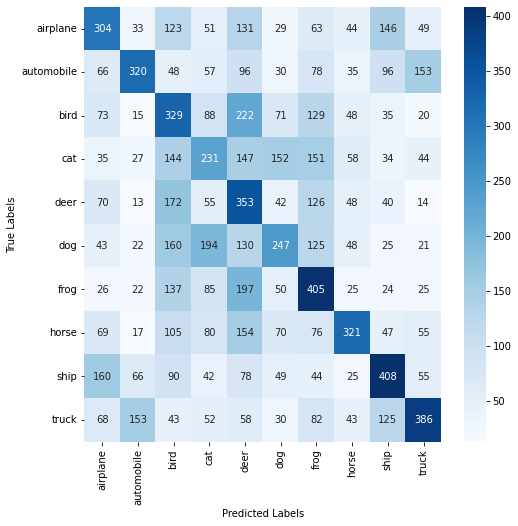

In [ ]:
# running ada_boost
final_num_estimators, best_depth, ada_val_reduced_acc, ada_val_reduced_pred = ada_boost(x_train_reduced, y_train, x_val_reduced, y_val)
print("AdaBoost with depth: ", best_depth ," and n_estimators: ", final_num_estimators, " gave the best score of: ", ada_val_reduced_acc)

# Let's present the confusion matrix
conf_matrix(ada_val_reduced_pred, y_val)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


linear  kernel gave the score of:  0.1347
poly  kernel gave the score of:  0.362
rbf  kernel gave the score of:  0.4439
kernel:  rbf  gave the best score of:  0.4439


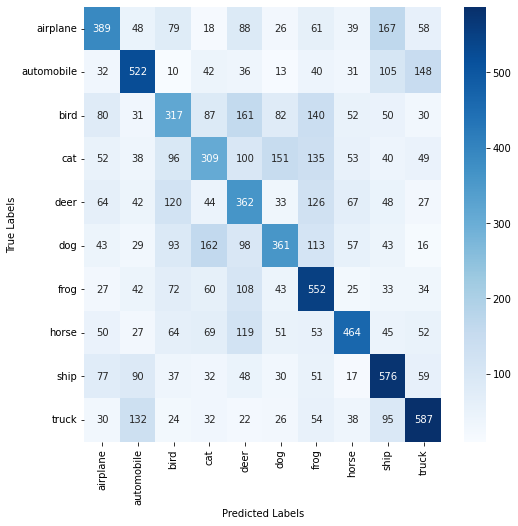

In [ ]:
# running SVM
final_kernel, svm_val_reduced_acc, svm_val_reduced_pred = svm_classifier(x_train_reduced, y_train, x_val_reduced, y_val)
print("kernel: ", final_kernel, " gave the best score of: ", svm_val_reduced_acc)

# Let's present the confusion matrix
conf_matrix(svm_val_reduced_pred, y_val)

default knn accuracy:  0.3478
neighbors amout:  9  gave the best score of:  0.3555


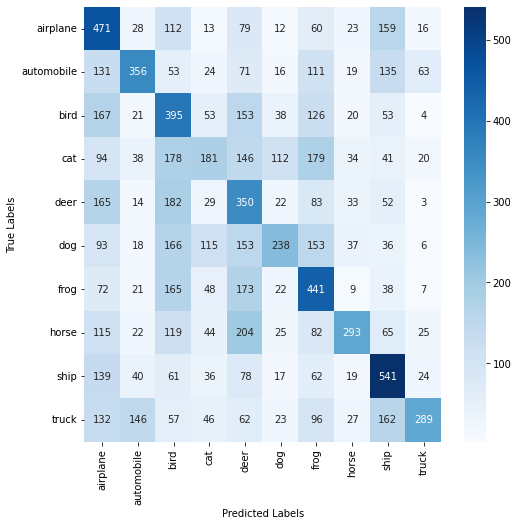

In [ ]:
# running knn
neighbors_amount, knn_val_reduced_acc, knn_val_reduced_pred = KNN(x_train_reduced, y_train, x_val_reduced, y_val)
print("neighbors amout: ", neighbors_amount, " gave the best score of: ", knn_val_reduced_acc)

# Let's present the confusion matrix
conf_matrix(knn_val_reduced_pred, y_val)

The best score so far we have accomplished was made by the SVM, by using rbf kernel (without the PCA) that gave the score of: 0.4529.

## Why we recieved such lower performances?
DecisionTree:
It may be that the decision tree is not suitable for this particular dataset, and that the hyperparameters of the model need to be tuned further than the one we performed.

Adaboost:
Maybe the reason Adaboost didn't perform well on our data is because we didn't use the right base estimator for this mission.

SVM:
SVM works well on datasets with a clear margin of separation, it could be that our data is highly overlapping or noisy.

KNN:
One possible reason that KNN didn't perform well on our data is because the dataset is high dimensional, and KNN tends to perform poorly in high-dimensional spaces.

Let's see if we can beat that score with a model we have not learned.

In [ ]:
# Convert the labels to one-hot encoding (the CNN can make better predictions on a one-hot encoded)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# **Model we havn't learned**
# **CNN**
Convolutional Neural Networks (CNNs) are a type of deep learning model that can automatically learn hierarchical representations of the input data by using convolutional layers, pooling layers, and fully connected layers. CNNs are particularly well-suited for image classification tasks, where the spatial relationships between the pixels are important.

## Challanges
We don't know this model and for that reason we learned about it and tried to understand how can we use this model on our data. For maximizing the predictions we ran it on different parameters and for that reason we presented two of our several tries.

First try

In [ ]:
# Define the model
cnn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
cnn_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
1250/1250 [==============================] - 89s 71ms/step - loss: 1.4956 - accuracy: 0.4642 - val_loss: 1.1914 - val_accuracy: 0.5793
Epoch 2/10
1250/1250 [==============================] - 88s 70ms/step - loss: 1.1678 - accuracy: 0.5878 - val_loss: 1.0332 - val_accuracy: 0.6407
Epoch 3/10
1250/1250 [==============================] - 86s 69ms/step - loss: 1.0376 - accuracy: 0.6335 - val_loss: 0.9617 - val_accuracy: 0.6629
Epoch 4/10
1250/1250 [==============================] - 89s 71ms/step - loss: 0.9433 - accuracy: 0.6662 - val_loss: 0.9669 - val_accuracy: 0.6644
Epoch 5/10
1250/1250 [==============================] - 88s 70ms/step - loss: 0.8837 - accuracy: 0.6896 - val_loss: 0.8818 - val_accuracy: 0.6921
Epoch 6/10
1250/1250 [==============================] - 86s 69ms/step - loss: 0.8234 - accuracy: 0.7107 - val_loss: 0.8370 - val_accuracy: 0.7112
Epoch 7/10
1250/1250 [==============================] - 87s 69ms/step - loss: 0.7706 - accuracy: 0.7298 - val_loss: 0.8202 -

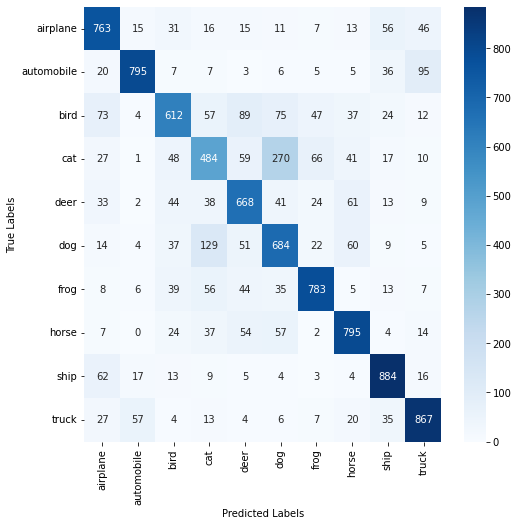

In [ ]:
# Train the model
history = cnn_1.fit(x_train, y_train, batch_size=32, epochs=10, validation_data= (x_val, y_val))

# make predictions on the validation data
cnn1_val_pred = cnn_1.predict(x_val)

# convert the one hot encoded back to regular (so we can calculate the accuracy score and present the confusion matrix)
cnn1_val_pred = np.argmax(cnn1_val_pred, axis=1)
y_val = np.argmax(y_val, axis=1)

# calculate the accuracy score
cnn1_val_acc = accuracy_score(y_val, cnn1_val_pred)
print('cnn1 validation accuracy:', cnn1_val_acc)

# Let's present the confusion matrix
conf_matrix(cnn1_val_pred, y_val)

# Converting back to one-hot encoding
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

Second try
We've added batch normalization after each Conv2D and dense layer, increased the number of filters in each Conv2D layer, added more dropout to prevent overfitting, and used the adam optimizer instead of SGD. These modifications should help improve our results.

In [ ]:
cnn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

cnn_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
625/625 [==============================] - 434s 688ms/step - loss: 1.7090 - accuracy: 0.4149 - val_loss: 1.6816 - val_accuracy: 0.4418
Epoch 2/10
625/625 [==============================] - 471s 754ms/step - loss: 1.1315 - accuracy: 0.5978 - val_loss: 0.9047 - val_accuracy: 0.6797
Epoch 3/10
625/625 [==============================] - 461s 737ms/step - loss: 0.9434 - accuracy: 0.6666 - val_loss: 0.8415 - val_accuracy: 0.7074
Epoch 4/10
625/625 [==============================] - 456s 730ms/step - loss: 0.8461 - accuracy: 0.7052 - val_loss: 0.8156 - val_accuracy: 0.7132
Epoch 5/10
625/625 [==============================] - 451s 722ms/step - loss: 0.7753 - accuracy: 0.7300 - val_loss: 0.7009 - val_accuracy: 0.7547
Epoch 6/10
625/625 [==============================] - 419s 670ms/step - loss: 0.7159 - accuracy: 0.7521 - val_loss: 0.6403 - val_accuracy: 0.7785
Epoch 7/10
625/625 [==============================] - 407s 651ms/step - loss: 0.6621 - accuracy: 0.7718 - val_loss: 0.6336 -

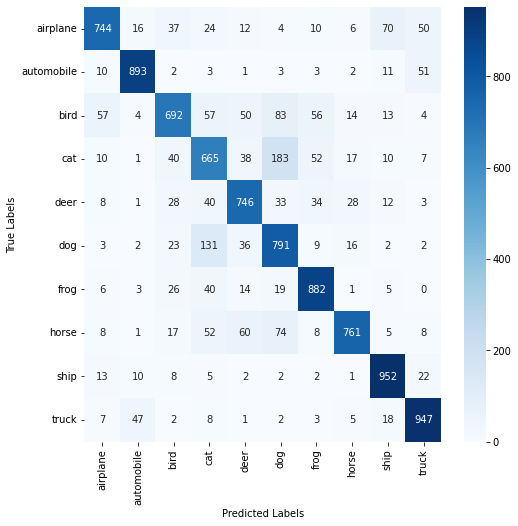

In [ ]:
# Train the model
history = cnn_2.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

# make predictions on the validation data
cnn2_val_pred = cnn_2.predict(x_val)

# convert the one hot encoded back to regular (so we can calculate the accuracy score and present the confusion matrix)
cnn2_val_pred = np.argmax(cnn2_val_pred, axis=1)
y_val = np.argmax(y_val, axis=1)

# calculate the accuracy score
cnn2_val_acc = accuracy_score(y_val, cnn2_val_pred)
print('cnn2 validation accuracy:', cnn2_val_acc)

# Let's present the confusion matrix
conf_matrix(cnn2_val_pred, y_val)

As we can see, the cnn gave us the best score of: 0.8073, and for that reason we will predict the test by using this model.

We can also see that our model predicted a lot of cats as dogs and vice verca, this means that the cat and the dog label classes has a lot of common features, which works out logically.

### Why did the CNN performed well?
One possible reason could be that our dataset consists of images, and CNNs are known to perform well on image classification tasks because they can extract meaningful features from the raw pixel data.

### Predicting the test

313/313 [==============================] - 23s 72ms/step
cnn2 test accuracy: 0.807


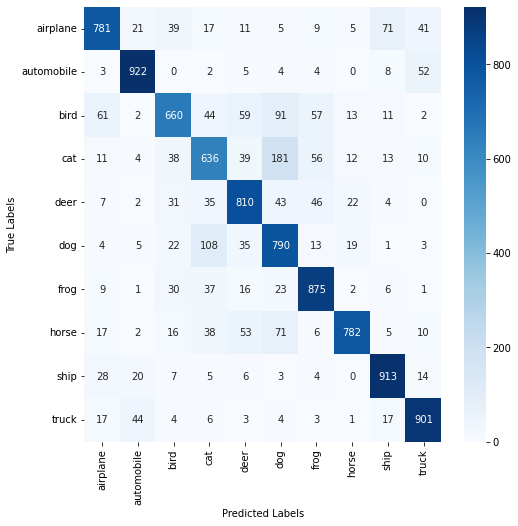

In [ ]:
# make predictions on the test data
cnn2_test_pred = cnn_2.predict(x_test)

# convert the one hot encoded back to regular (so we can calculate the accuracy score and present the confusion matrix)
cnn2_test_pred = np.argmax(cnn2_test_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# calculate the accuracy score
cnn2_test_acc = accuracy_score(y_test, cnn2_test_pred)
print('cnn2 test accuracy:', cnn2_test_acc)

# Let's present the confusion matrix
conf_matrix(cnn2_test_pred, y_test)

### Conclusion
From the models we learned in the course

The best model (between the models that we checked) for our dataset is: CNN.

Our test score is: 0.807.